In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define the transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
# Define the paths to the dataset folders
data_path = "C:/Users/fazee/Desktop/dataset_folder"

In [4]:
# Load the dataset
dataset = ImageFolder(root=data_path, transform=transform)


In [5]:
# Split the dataset into training and testing sets (80% for training, 20% for testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


In [6]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [7]:
# Define the ResNet18 model
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.resnet18 = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
        num_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_features, 2)

    def forward(self, x):
        return self.resnet18(x)


In [8]:
# Initialize the model and move it to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)


Downloading: "https://github.com/pytorch/vision/zipball/main" to C:\Users\fazee/.cache\torch\hub\main.zip
c:\Users\fazee\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\fazee\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\fazee/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [9]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
# Training the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")


Epoch 1/10, Loss: 0.006325505929999054
Epoch 2/10, Loss: 0.0024567343687522227
Epoch 3/10, Loss: 0.0006284669754677453
Epoch 4/10, Loss: 0.000428097986150533
Epoch 5/10, Loss: 0.0009679728042101488
Epoch 6/10, Loss: 0.0017194211395690218
Epoch 7/10, Loss: 0.0003863856734824367
Epoch 8/10, Loss: 0.00012104983907192945
Epoch 9/10, Loss: 0.00018342176626902075
Epoch 10/10, Loss: 0.0002941634782473557


In [12]:
# Evaluating the model and visualizing results
model.eval()
correct = 0
total = 0
predictions = []
ground_truth = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append the predictions and ground truth labels for visualization
        predictions.extend(predicted.cpu().numpy())
        ground_truth.extend(labels.cpu().numpy())

print(f"Test Accuracy: {100 * correct / total}%")


Test Accuracy: 95.0%


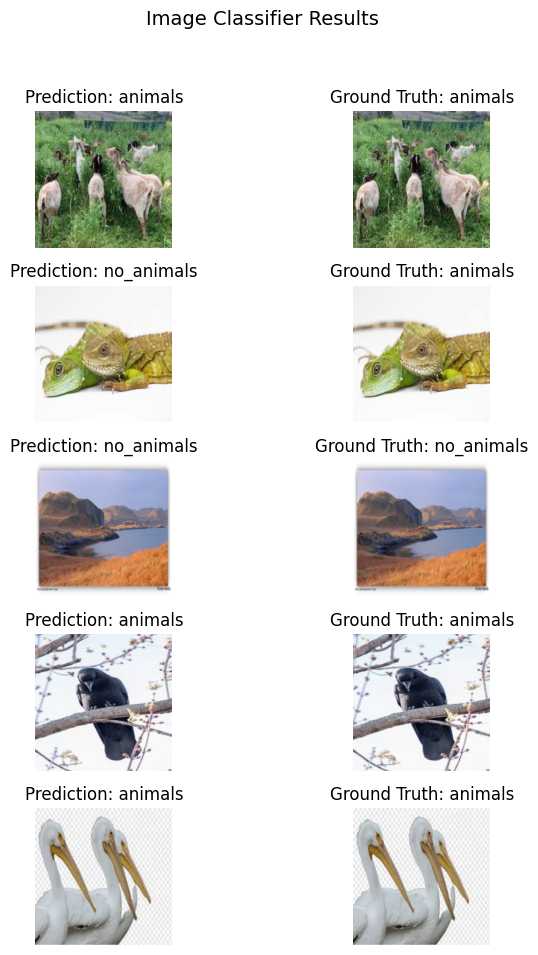

In [13]:
# Visualization
classes = dataset.classes
num_display_images = 5

fig, axes = plt.subplots(num_display_images, 2, figsize=(8, 2 * num_display_images))
fig.suptitle("Image Classifier Results", fontsize=14)

for i in range(num_display_images):
    image, label = test_dataset[i]
    image = image.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        predicted_label = classes[predicted.item()]
        ground_truth_label = classes[ground_truth[i]]

    image = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f"Prediction: {predicted_label}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(image)
    axes[i, 1].set_title(f"Ground Truth: {ground_truth_label}")
    axes[i, 1].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()